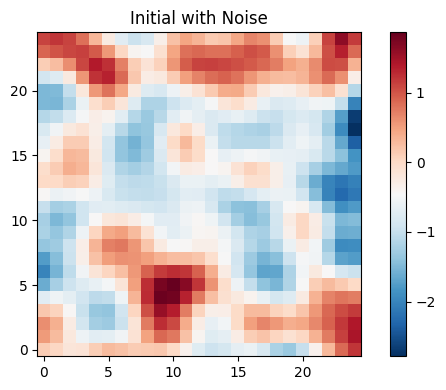

In [93]:
import numpy as np
import pandas as pd
import gstools as gs
from sklearn.preprocessing import KBinsDiscretizer
from hmmlearn import hmm
import matplotlib.pyplot as plt

# 定义数据维度
dimensionxy = 25

# 生成数据
x = np.linspace(0, 25, 25)
y = np.linspace(0, 25, 25)
XX, YY = np.meshgrid(x, y)

# 第一个数据
model = gs.Gaussian(dim=2, var=1, len_scale=3)
srf = gs.SRF(model, mean=0.)
srf((x, y), mesh_type='structured')
B0 = srf((x, y), mesh_type='structured', seed=100)

# 定义状态数
n_states = 5
est = KBinsDiscretizer(n_bins=n_states, encode='ordinal', strategy='uniform')
B_discretized = est.fit_transform(B0).astype(int)


# # 可视化
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

# 原始随机场带噪声
im0 = axes.imshow(B0, origin='lower', cmap='RdBu_r')
axes.set_title('Initial with Noise')
fig.colorbar(im0, ax=axes)


plt.tight_layout()
plt.show()


In [94]:
import numpy as np
import pandas as pd
import gstools as gs
from sklearn.preprocessing import KBinsDiscretizer
from hmmlearn import hmm

# 定义数据维度
dimensionxy = 25
n_states = 5


# 定义状态数
est = KBinsDiscretizer(n_bins=n_states, encode='ordinal', strategy='uniform')
B_discretized = est.fit_transform(B0).astype(int)

def process_data_with_hmm(B_discretized):
    # 准备HMM模型
    model = hmm.MultinomialHMM(n_components=n_states, n_iter=100, random_state=42)
    
    # 将前25行的数据展开成序列
    sequence = B_discretized[:dimensionxy, :].reshape(-1, 1)
    model.fit(sequence)

    # 预测第26行的状态
    predicted_states = []
    for day in range(dimensionxy):
        last_state = B_discretized[-1, day]
        next_state_probabilities = model.transmat_[int(last_state)]
        predicted_state = np.random.choice(np.arange(n_states), p=next_state_probabilities)
        
        # 加入人为因素的扰动
        error_margin = np.random.laplace(0.01, 0.05) + np.random.poisson(0.01) + np.random.normal(0.01, 0.05)
        predicted_state_with_error = int(predicted_state + error_margin)
        
        # 确保扰动后的状态在合法范围内
        predicted_state_with_error = np.clip(predicted_state_with_error, 0, n_states - 1)
        
        predicted_states.append(predicted_state_with_error)

    return predicted_states

def calcuCirculation_for_point(B_object, time):
    all_processed_values = []
    results_df = pd.DataFrame()
    if time == 2:
        for i in range(1, time):
            processed_value = process_data_with_hmm(B_object)
            all_processed_values.append(pd.Series(processed_value, name=f'Out0'))
        results_df = pd.concat(all_processed_values, axis=1)
        results_df.to_csv("initial-out/pred_nonoisy_initial.csv", index=False)
    if time != 2:
        for i in range(1, time):
            processed_value = process_data_with_hmm(B_object)
            all_processed_values.append(pd.Series(processed_value, name=f'Out{i}'))
        
        results_df = pd.concat(all_processed_values, axis=1)
        results_df.to_csv("repro-out/pred_nonoisy.csv", index=False)
        # print(results_df)

# 运行计算，指定循环次数
times = 1001
# calcuCirculation_for_point(B_discretized, 2)
calcuCirculation_for_point(B_discretized, times)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows

In [95]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from itertools import combinations
import warnings 
warnings.filterwarnings("ignore")

# 生成示例数据
df = pd.read_csv("./repro-out/pred_nonoisy.csv")

out0 =pd.read_csv("./initial-out/pred_nonoisy_initial.csv")
x= df.index
data = df.copy()

# 筛选data_repro中包含新列的部分
filtered_data_repro = data[[f'Out{i}' for i in range(1, 1001)]]

cluster_counts = filtered_data_repro.apply(pd.Series.value_counts, axis=1).fillna(0)
cluster_frequencies = cluster_counts.div(cluster_counts.sum(axis=1), axis=0)

# filtered_data_initial = data[[f'Out0']]


relative_frequency=[]

# 创建频率分布图的函数
def plot_histogram(row_data, row_index):
    initial_value=out0.loc[row_index,:].values[0]
    unique, counts = np.unique(row_data, return_counts=True)
    frequencies = dict(zip(unique, counts))
    # print(frequencies)
    
    categories = [0, 1, 2, 3, 4]
    frequency_values = [frequencies.get(category, 0) for category in categories]
    # 确定initial_value所在的类别及其频率
    initial_category = int(initial_value)
    initial_frequency = frequencies.get(initial_category, 0)
    relative_frequency.append(initial_frequency / len(row_data)) 
    # print(initial_relative_frequency)

    # plt.figure(figsize=(10, 6))
    # plt.bar(categories, frequency_values, tick_label=categories,alpha=0.3,label="Reproduced values")
    # plt.title(f'Frequency Distribution of Row {row_index} \n The probability of reproducbility is {initial_frequency / len(row_data) *100}%')
    # plt.axvline(x=initial_category, color='red', linestyle='dashed', linewidth=2, label=f'Initial value: {initial_value}')
    # plt.legend()
    # plt.xlabel('Category')
    # plt.ylabel('Frequency')
    # plt.ylim(0, max(frequency_values) + 10)  # Adjust ylim for better visualization
    # plt.show()

# 为每一行绘制直方图 filtered_data_repro.shape[0]
# print(filtered_data_repro.loc[0,:])

# filtered_data_repro= data2.iloc[:,1:1001]
# print(filtered_data_repro)
for i in range(1,filtered_data_repro.shape[0]):
    plot_histogram(filtered_data_repro.loc[i,:], i)

# 计算initial_relative_frequency数组的期望（均值）
expected_value = np.mean(relative_frequency)
print("Expected Value of Initial Relative Frequencies:", expected_value)


Expected Value of Initial Relative Frequencies: 0.6587083333333333


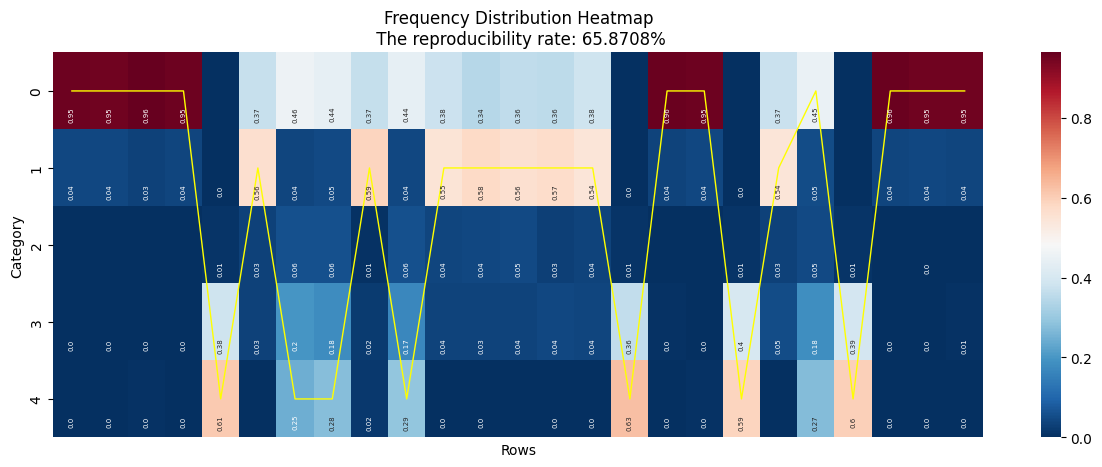

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 仅选择前20行的数据
number = df.shape[0]
repro = df.iloc[:number, :]
initial = out0.iloc[:number, :]

# 创建一个矩阵来存储频率分布
frequency_matrix = np.zeros((repro.shape[0], 5))  # 修改为6列，以包括0-5的所有分类

# 填充频率矩阵
for i in range(repro.shape[0]):
    row_data = repro.loc[i, :]
    unique, counts = np.unique(row_data, return_counts=True)
    frequencies = dict(zip(unique, counts))
    for category in range(5):  # 修改为 range(6)，以确保涵盖类别0
        frequency_matrix[i, category] = frequencies.get(category, 0) / len(row_data)

# 创建一个矩阵来存储注释（只显示值大于0的标签）
annotations = np.where(frequency_matrix > 0, np.round(frequency_matrix, 2), '')

# 绘制热力图
plt.figure(figsize=(15, 5))

ax = sns.heatmap(frequency_matrix.T, annot=annotations.T, fmt="", xticklabels=False, yticklabels=[0, 1, 2, 3, 4], cmap="RdBu_r", cbar=True,
                 annot_kws={"size": 5, "ha": "center", "va": "center", "rotation": 90,"clip_on": True}) #cmap="viridis"

plt.title(f'Frequency Distribution Heatmap\n The reproducibility rate: {round(expected_value*100,4)}%')
plt.ylabel('Category')
plt.xlabel('Rows')

# 调整标签的位置
for text in ax.texts:
    text.set_y(float(text.get_position()[1]) + 0.3)

# 添加表示filtered_data_initial的线
initial_values = initial['Out0'].values   # 将值转换为索引
plt.plot(np.arange(0.5, repro.shape[0] + 0.5), initial_values + 0.5, color='yellow', linewidth=1, label='Initial Value')
plt.savefig("repro-out/heatmap.svg")
plt.show()


计算 ARI 统计量:
总误差(ARI): (0.1292, 0.6661)
随机误差(ARI): (0.0972, 0.5914)
总误差覆盖随机-置信区间覆盖率: 0.8609；概率0.9413
随机覆盖总-置信区间覆盖率: 0.9354；概率0.9413

计算 NMI 统计量:
总误差(NMI): (0.2961, 0.7240)
随机误差(NMI): (0.2538, 0.6220)
总误差覆盖随机-置信区间覆盖率: 0.7617；概率0.9231
随机覆盖总-置信区间覆盖率: 0.8853；概率0.9231

计算 Kappa 统计量:
总误差(Kappa): (0.2840, 0.7567)
随机误差(Kappa): (0.1379, 0.6394)
总误差覆盖随机-置信区间覆盖率: 0.7519；概率0.7872
随机覆盖总-置信区间覆盖率: 0.7088；概率0.7872


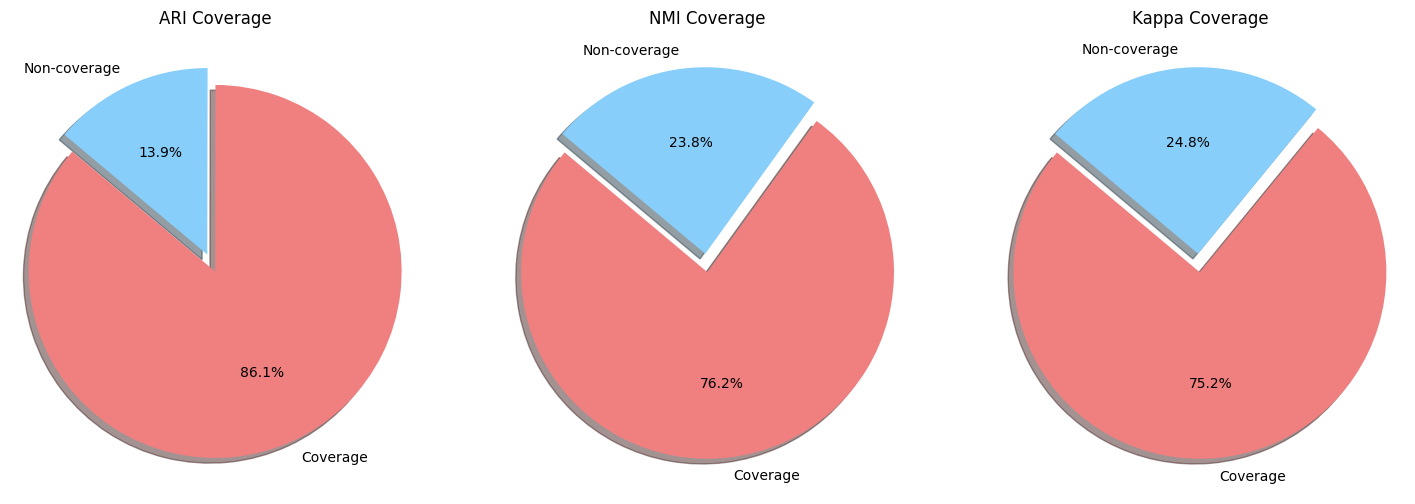

In [97]:
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, cohen_kappa_score
from itertools import combinations
import scipy.stats as stats

# 设定随机种子以确保结果一致


# 计算置信区间
def calculate_confidence_interval(values, alpha=0.05):
    values = np.sort(values)
    lower_bound = np.percentile(values, alpha / 2 * 100)
    upper_bound = np.percentile(values, (1 - alpha / 2) * 100)
    return lower_bound, upper_bound

# 蒙特卡洛抽样并计算指定类型的统计量
def monteCarloMethod(num_samples, data, stat_type):
    monteCarlo_statistics_values = []
    sampled_combinations = [np.random.choice(data.columns, 2, replace=False) for _ in range(num_samples)]
    
    for comb in sampled_combinations:
        i, j = comb
        monteCarlo_statistics_values.append(calculate_statistic_values(data[i], data[j], stat_type))
    
    return monteCarlo_statistics_values



# 计算指定类型的统计量
def calculate_statistic_values(data1, data2, stat_type):
    data1 = data1.values.ravel()  # 或者使用 data1.flatten() 
    if stat_type == "ARI":
        return adjusted_rand_score(data1, data2)
    elif stat_type == "NMI":
        return normalized_mutual_info_score(data1, data2)
    elif stat_type == "Kappa":
        return cohen_kappa_score(data1, data2)

# 计算覆盖率
def calculate_coverage(interval1, interval2):
    L1, U1 = interval1
    L2, U2 = interval2
    L_overlap = max(L1, L2)
    U_overlap = min(U1, U2)
    if L_overlap > U_overlap:
        return 0.0
    overlap_length = U_overlap - L_overlap
    length1 = U1 - L1
    coverage = overlap_length / length1
    return coverage

def calculate_coverage2(interval1, interval2):
    # interval1 总误差
    # interval2 随机误差
    L1, U1 = interval1
    L2, U2 = interval2
    L_overlap, U_overlap = max(L1, L2), min(U1, U2)
    if L_overlap > U_overlap:
        return 0.0
    overlap_length = U_overlap - L_overlap
    length1, length2 = U1 - L1, U2 - L2
    coverage = overlap_length / length2
    return coverage 
# def calculate_proportion(values, lower_bound, upper_bound):
#     # value
#     return np.sum((values >= lower_bound) & (values <= upper_bound)) / len(values)
def calculate_proportion(values, lower_bound, upper_bound):
    # 确保 values 是一个一维数组或列表
    values = np.asarray(values).flatten()
    
    common_count = 0
    total_count = len(values)
    for value in values:
        if lower_bound <= value <= upper_bound:
            common_count += 1
            
    return common_count / total_count

# 数据加载
# data_df = pd.read_csv('repro-out/filtered_data.csv')
# filtered_data_repro = data_df[[f'new_Out{i}' for i in range(1, 1001)]]
# out0 = data_df['new_Out0']

# 生成示例数据
data_df = pd.read_csv("./repro-out/pred_nonoisy.csv")
filtered_data_repro = data_df[[f'Out{i}' for i in range(1, 1001)]]

out0 = data_df["Out0"]=data_df["cluster"]=pd.read_csv("./initial-out/pred_nonoisy_initial.csv")

# 定义要计算的统计量类型
stat_types = ["ARI", "NMI", "Kappa"]  # 可选值："ARI", "NMI", "Kappa"


fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for idx, stat_type in enumerate(stat_types):
    print(f"\n计算 {stat_type} 统计量:") 
    # 计算原始结果与复现结果的指定统计量
    real_values = [calculate_statistic_values(out0, filtered_data_repro[f'Out{i}'], stat_type) for i in range(1, 1001)]
    # 计算置信区间-----总误差
    ci_low, ci_high = calculate_confidence_interval(real_values)
    # -----随机误差
    monteCarlo_values = monteCarloMethod(10000, filtered_data_repro, stat_type)
    ci_low_mc_random, ci_high_mc_random = calculate_confidence_interval(monteCarlo_values)
    print(f"总误差({stat_type}): ({ci_low:.4f}, {ci_high:.4f})")
    print(f"随机误差({stat_type}): ({ci_low_mc_random:.4f}, {ci_high_mc_random:.4f})")
    # 计算覆盖率

    ratio_original = calculate_proportion(monteCarlo_values, ci_low, 1)


    coverage = calculate_coverage((ci_low, ci_high), (ci_low_mc_random, ci_high_mc_random))
    coverage2 = calculate_coverage2((ci_low, ci_high), (ci_low_mc_random, ci_high_mc_random))
    print(f"总误差覆盖随机-置信区间覆盖率: {coverage:.4f}；概率{ratio_original}")
    print(f"随机覆盖总-置信区间覆盖率: {coverage2:.4f}；概率{ratio_original}")

     # 绘制覆盖率的饼图
    
    # labels = ['Coverage', 'Non-coverage']
    # sizes = [coverage, 1-coverage]
    # colors = ['lightcoral', 'lightskyblue']
    # explode = (0.1, 0)  # 突出显示覆盖率
    # ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
    #        shadow=True, startangle=140)
    # ax.axis('equal')
        # 绘制覆盖率的饼图
    labels = ['Coverage', 'Non-coverage']
    sizes = [coverage, 1-coverage]
    colors = ['lightcoral', 'lightskyblue']
    explode = (0.1, 0)  # 突出显示覆盖率
    axs[idx].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                 shadow=True, startangle=140)
    axs[idx].axis('equal')
    axs[idx].set_title(f'{stat_type} Coverage')

plt.title(f'{stat_type} Coverage')
plt.show()


In [98]:
from sklearn.metrics import (
    adjusted_rand_score, 
    adjusted_mutual_info_score, 
    homogeneity_completeness_v_measure, 
    fowlkes_mallows_score, 
    jaccard_score
)

def calculate_clustering_similarity(true_labels, predicted_labels):
    similarity_measures = {
        "Adjusted Rand Index": adjusted_rand_score,
        "Adjusted Mutual Information": adjusted_mutual_info_score,
        "Homogeneity": lambda x, y: homogeneity_completeness_v_measure(x, y)[0],
        "Completeness": lambda x, y: homogeneity_completeness_v_measure(x, y)[1],
        "V-Measure": lambda x, y: homogeneity_completeness_v_measure(x, y)[2],
        "Fowlkes-Mallows Index": fowlkes_mallows_score,
        "Jaccard Index": lambda x, y: jaccard_score(
            [1 if label == 0 else 0 for label in x], 
            [1 if label == 0 else 0 for label in y]
        )  # Example for binary case, adjust accordingly for multi-class
    }
    
    results = {}
    for measure_name, measure_func in similarity_measures.items():
        results[measure_name] = measure_func(true_labels, predicted_labels)
    
    return results

# 示例聚类标签
labels_true = out0
labels_pred = data["Out18"]

# 确保标签是1D的
labels_true = labels_true.values.ravel()
labels_pred = labels_pred.values.ravel()

# 计算相似性
similarity_results = calculate_clustering_similarity(labels_true, labels_pred)

# 打印结果
for measure, result in similarity_results.items():
    print(f"{measure}: {result:.4f}")

Adjusted Rand Index: 0.3028
Adjusted Mutual Information: 0.3171
Homogeneity: 0.4288
Completeness: 0.3873
V-Measure: 0.4070
Fowlkes-Mallows Index: 0.5213
Jaccard Index: 0.5714


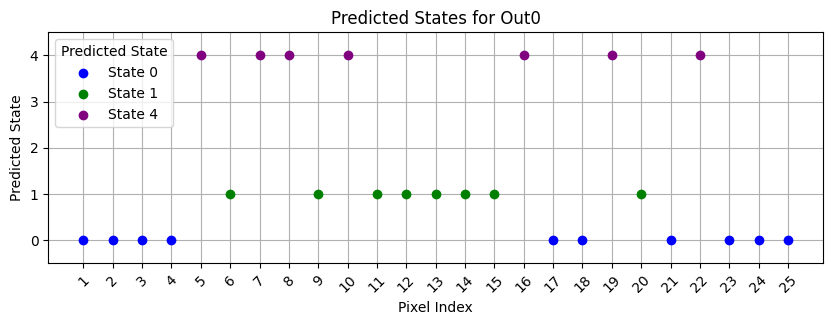

In [124]:
# 将数据展开为一维数组
data_values = out0.values.flatten()

# 创建颜色映射
colors = {0: 'blue', 1: 'green', 2: 'orange', 3: 'red', 4: 'purple'}

# 创建图形
plt.figure(figsize=(10, 3))

# 为每个分类状态绘制不同颜色的点
for value in np.unique(data_values):
    indices = np.where(data_values == value)
    plt.scatter(indices, data_values[indices], color=colors[value], label=f'State {value}',zorder=3)

# 绘制网格线在散点图之下
plt.grid(True, zorder=0)

# 确保散点图在网格线之上
plt.xlabel('Pixel Index')
plt.ylabel('Predicted State')
plt.title('Predicted States for Initial output')
plt.xticks(range(len(data_values)), labels=[f'{i+1}' for i in range(len(data_values))], rotation=45)
plt.yticks(np.arange(0, 5, 1))  # 设置 y 轴刻度为 0 到 4
plt.ylim(-0.5, 4.5)  # 限制 y 轴范围从 -0.1 到 4.01
plt.legend(title='Predicted State')  # 添加图例

plt.show()

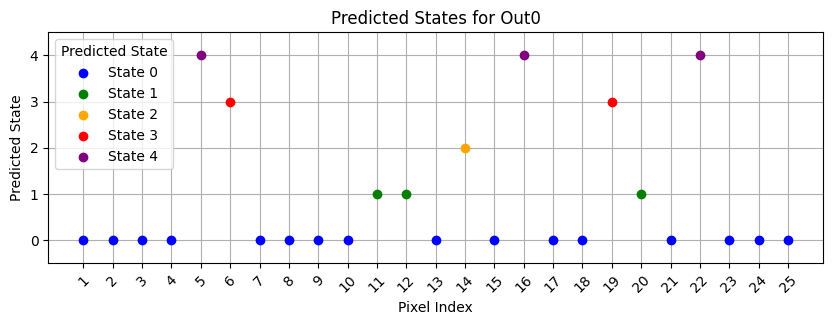

In [130]:
# 将数据展开为一维数组
data_values = data["Out190"].values.flatten()

# 创建颜色映射
colors = {0: 'blue', 1: 'green', 2: 'orange', 3: 'red', 4: 'purple'}

# 创建图形
plt.figure(figsize=(10, 3))

# 为每个分类状态绘制不同颜色的点
for value in np.unique(data_values):
    indices = np.where(data_values == value)
    plt.scatter(indices, data_values[indices], color=colors[value], label=f'State {value}',zorder=3)

# 绘制网格线在散点图之下
plt.grid(True, zorder=0)

# 确保散点图在网格线之上
plt.xlabel('Pixel Index')
plt.ylabel('Predicted State')
plt.title('Predicted States for One Reproduction Case')
plt.xticks(range(len(data_values)), labels=[f'{i+1}' for i in range(len(data_values))], rotation=45)
plt.yticks(np.arange(0, 5, 1))  # 设置 y 轴刻度为 0 到 4
plt.ylim(-0.5, 4.5)  # 限制 y 轴范围从 -0.1 到 4.01
plt.legend(title='Predicted State')  # 添加图例

plt.show()